# Electric Car

Copyright 2017 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)


In [1]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

### Electric car

The goal of this case study is to use simulation to guide the design of a car intended to accelerate from standing to 100 kph as quickly as possible, under the constraints of the [Formula SAE Electric](https://www.sae.org/attend/student-events/formula-sae-electric).  The [world record for this event](https://www.youtube.com/watch?annotation_id=annotation_2297602723&feature=iv&src_vid=I-NCH8ct24U&v=n2XiCYA3C9s), using a car that meets the competition requirements, is 1.513 seconds.

We'll start with a simple model that takes into account the characteristics of the motor and vehicle:

* The motor is an [Emrax 228 high voltage axial flux synchronous permanent magnet motor](http://emrax.com/products/emrax-228/); according to the [data sheet](http://emrax.com/wp-content/uploads/2017/01/emrax_228_technical_data_4.5.pdf), its maximum torque is 240 Nm, at 0 rpm.  But maximum torque decreases with motor speed; at 5000 rpm, maximum torque is 216 Nm.

* The motor is connected to the drive axle with a chain drive with speed ratio 13:60 or 1:4.6; that is, the axle rotates once for each 4.6 rotations of the motor.

* The radius of the tires is 0.26 meters.

* The weight of the vehicle, including driver, is 300 kg.

To start, we will assume no slipping between the tires and the road surface, no air resistance, and no rolling resistance.  Then we will relax these assumptions one at a time.

* First we'll add drag, assuming that the frontal area of the vehicle is 0.6 square meters, with coefficient of drag 0.6.

* Next we'll add rolling resistance, assuming a coefficient of 0.2.

* Finally we'll compute the peak acceleration to see if the "no slip" assumption is credible.

We'll use this model to estimate the potential benefit of possible design improvements, including decreasing drag and rolling resistance, or increasing the speed ratio.

We'll start by creating a Params object in base metric units:

In [39]:
params = dict(r_wheel=0.26,
                speed_ratio=13/60,
                C_rr=0.2,
                C_d=0.5,
                area=0.6,
                rho=1.2,
                mass=300)

`make_system` creates the initial state, `init`, and constructs an `interp1d` object that represents torque as a function of motor speed.  `interpolate_torque` is an object, but it is a function: when given a value in rpms, it will return a value for the torque at that rpm value.  The `extrapolate` option means that even if it is given an rpm value outside the data range (above 5000 rpm, for instance), it will still provide a result.

In [40]:
from scipy.interpolate import interp1d

def make_system(params):
    """Make a system object.
    
    params: Params object
    
    returns: System object
    """
    
    r_wheel, speed_ratio, C_rr, C_d, area, rho, mass = params.values()
    
    init = pd.Series(dict(x=0, v=0))
    
    rpms = [0, 2000, 5000]
    torques = [240, 240, 216]
    interpolate_torque = interp1d(rpms,torques,fill_value="extrapolate")
    
    return dict(r_wheel=r_wheel, speed_ratio=speed_ratio,C_rr=C_rr,
                C_d=C_d, area=area, rho=rho, mass=mass, init=init,
                  interpolate_torque=interpolate_torque,
                  t_end=3)

Testing `make_system`

In [41]:
system = make_system(params)

In [42]:
system['init']

x    0
v    0
dtype: int64

### Torque and speed

The relationship between torque and motor speed is taken from the [Emrax 228 data sheet](http://emrax.com/wp-content/uploads/2017/01/emrax_228_technical_data_4.5.pdf).  The following functions reproduce the red dotted line that represents peak torque, which can only be sustained for a few seconds before the motor overheats.

In [43]:
def compute_torque(omega, system):
    """Maximum peak torque as a function of motor speed.
    
    omega: motor speed in radian/s
    system: System object
    
    returns: torque in Nm
    """
    factor = 60/(2 * 3.1415)
    x = omega * factor
    interp_torque = system['interpolate_torque']
    return interp_torque(x)

In [44]:
compute_torque(0, system)

array(240.)

In [45]:
# To use compute torque, we need to convert rpms to radian/s
factor = 60/(2 * 3.1415)
omega = 5000/factor

compute_torque(omega, system)

array(216.)

Plot the whole curve.

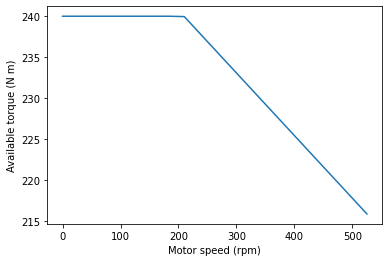

In [46]:
from matplotlib.pyplot import plot

xs = linspace(0, 525, 21)      # in radian/s
taus = [compute_torque(x, system) for x in xs]
torque_vs_rpms = pd.Series(data=taus,index=xs,dtype=np.float64)
torque_vs_rpms.plot(xlabel='Motor speed (rpm)',
         ylabel='Available torque (N m)');


### Simulation

Here's the slope function that computes the maximum possible acceleration of the car as a function of it current speed.

In [47]:
def slope_func(t,state,system):
    """Computes the derivatives of the state variables.

    t: time
    state: State object
    system: System object 
    
    returns: sequence of derivatives
    """
    x, v = state
    r_wheel, speed_ratio, mass = system['r_wheel'], system['speed_ratio'], system['mass']
    
    # use velocity, v, to compute angular velocity of the wheel
    omega2 = v / r_wheel
    
    # use the speed ratio to compute motor speed
    omega1 = omega2 / speed_ratio
    
    # look up motor speed to get maximum torque at the motor
    tau1 = compute_torque(omega1, system)
    
    # compute the corresponding torque at the axle
    tau2 = tau1 / speed_ratio
    
    # compute the force of the wheel on the ground
    F = tau2 / r_wheel
    
    # compute acceleration
    a = F/mass

    return v, a      

Testing `slope_func` at linear velocity 10 m/s.

In [48]:
test_state = pd.Series(dict(x=0, v=10))

In [49]:
slope_func(0,test_state, system)

(10, 14.201183431952662)

Now we can run the simulation.

In [50]:
results, details = run_solve_ivp(system, slope_func)
details

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 44
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001D2C0905550>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.61558556e+00, 3.00000000e+00])
 t_events: None
        y: array([[0.00000000e+00, 7.10059172e-08, 8.59171598e-06, 8.74863905e-04,
        8.76440947e-02, 8.76105280e+00, 4.75420464e+01, 6.20571626e+01],
       [0.00000000e+00, 1.42011834e-03, 1.56213018e-02, 1.57633136e-01,
        1.57775148e+00, 1.57400714e+01, 3.54179021e+01, 4.00762083e+01]])
 y_events: None

And look at the results.

In [51]:
results.tail()

,x,v
2.88,57.334204,38.637454
2.91,58.498745,38.998443
2.94,59.674102,39.358563
2.97,60.860250,39.717818
3.00,62.057163,40.076208


After 3 seconds, the vehicle could be at 40 meters per second, in theory, which is 144 kph.

In [52]:
v_final = results.iloc[-1]
ms_to_km = 3600/1000
v_final_kph = v_final * ms_to_km

Plotting `x`

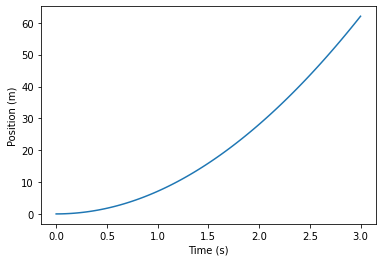

In [54]:
def plot_position(results):
    results.x.plot(label='x', xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

Plotting `v`

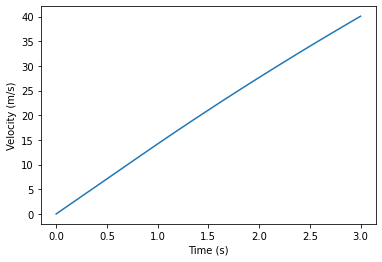

In [55]:
def plot_velocity(results):
    results.v.plot(label='x', xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

### Stopping at 100 kph

We'll use an event function to stop the simulation when we reach 100 kph.

In [56]:
def event_func(t,state, system):
    """Stops when we get to 100 km/hour.
    
    state: State object
    t: time
    system: System object 
    
    returns: difference from 100 km/hour
    """
    x, v = state
    
    # convert to km/hour
    ms_to_km = 3600/1000
    v = v * ms_to_km
    
    return v - 100     

In [57]:
results, details = run_solve_ivp(system, slope_func, events=event_func)
details

  message: 'A termination event occurred.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001D2C19F87F0>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.00970018e+00])
 t_events: [array([2.00970018])]
        y: array([[0.00000000e+00, 7.10059172e-08, 8.59171598e-06, 8.74863905e-04,
        8.76440947e-02, 8.76105280e+00, 2.83786066e+01],
       [0.00000000e+00, 1.42011834e-03, 1.56213018e-02, 1.57633136e-01,
        1.57775148e+00, 1.57400714e+01, 2.77777778e+01]])
 y_events: [array([[28.37860655, 27.77777778]])]

Here's what the results look like.

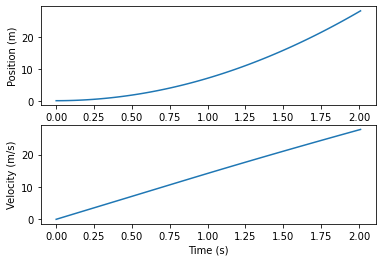

In [58]:
from matplotlib.pyplot import subplot

subplot(2, 1, 1)
plot_position(results)

subplot(2, 1, 2)
plot_velocity(results)

According to this model, we should be able to make this run in just over 2 seconds.

In [61]:
t_final = results.index[-1]
t_final

2.0097001757203663

At the end of the run, the car has gone about 28 meters.

In [63]:
state = results.iloc[-1]
state

x    28.378607
v    27.777778
Name: 2.0097001757203663, dtype: float64

If we send the final state back to the slope function, we can see that the final acceleration is about 13 $m/s^2$, which is about 1.3 times the acceleration of gravity.

In [64]:
v, a = slope_func(0,state, system)
a 

12.918880471747803

In [65]:
g = 9.8
(a / g)

1.3182531093620207

It's not easy for a vehicle to accelerate faster than `g`, because that implies a coefficient of friction between the wheels and the road surface that's greater than 1.  But racing tires on dry asphalt can reach a peak coefficient near 1.5.

So it's possible that our no slip assumption is valid, but only under ideal conditions, where weight is distributed equally on four tires, and all tires are driving.

### Exercise 1

How much time do we lose because maximum torque decreases as motor speed increases?  Run the model again with no drop off in torque and see how much time it saves.

## Drag

In this section we'll see how much effect drag has on the results.

Here's a function to compute drag force, as we saw in Chapter 21.

In [66]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    system: System object
    
    returns: drag force
    """
    rho, C_d, area = system['rho'], system['C_d'], system['area']
    
    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    return f_drag

We can test it with a velocity of 20 m/s.

In [67]:
drag_force(20, system)

-72.0

Here's the resulting acceleration of the vehicle due to drag.


In [69]:
drag_force(20, system) / system['mass']

-0.24

We can see that the effect of drag is not huge, compared to the acceleration we computed in the previous section, but it is not negligible.

Here's a modified slope function that takes drag into account.

In [70]:
def slope_func2(t, state, system):
    """Computes the derivatives of the state variables.
    
    state: State object
    t: time
    system: System object 
    
    returns: sequence of derivatives
    """
    x, v = state
    r_wheel, speed_ratio, mass = system['r_wheel'], system['speed_ratio'], system['mass']
    
    omega2 = v / r_wheel
    omega1 = omega2 / speed_ratio
    tau1 = compute_torque(omega1, system)
    tau2 = tau1 / speed_ratio
    F = tau2 / r_wheel
    a_motor = F / mass
    a_drag = drag_force(v, system) / mass
    
    a = a_motor + a_drag
    return v, a 

And here's the next run.

In [71]:
results2, details = run_solve_ivp(system, slope_func2, events=event_func)
details

  message: 'A termination event occurred.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001D2C1A741F0>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.03392446e+00])
 t_events: [array([2.03392446])]
        y: array([[0.00000000e+00, 7.10059172e-08, 8.59171596e-06, 8.74863752e-04,
        8.76425584e-02, 8.74594337e+00, 2.88919477e+01],
       [0.00000000e+00, 1.42011834e-03, 1.56213017e-02, 1.57633081e-01,
        1.57769617e+00, 1.56861604e+01, 2.77777778e+01]])
 y_events: [array([[28.89194767, 27.77777778]])]

The time to reach 100 kph is a bit higher.

In [73]:
t_final2 = results2.index[-1]
t_final2

2.0339244631366507

But the total effect of drag is only about 2/100 seconds.

In [74]:
t_final2 - t_final

0.02422428741628435

That's not huge, which suggests we might not be able to save much time by decreasing the frontal area, or coefficient of drag, of the car.

### Rolling resistance

Next we'll consider [rolling resistance](https://en.wikipedia.org/wiki/Rolling_resistance), which the force that resists the motion of the car as it rolls on tires.  The cofficient of rolling resistance, `C_rr`, is the ratio of rolling resistance to the normal force between the car and the ground (in that way it is similar to a coefficient of friction).

The following function computes rolling resistance.

In [77]:
def rolling_resistance(system):
    """Computes force due to rolling resistance.
    
    system: System object
    
    returns: force
    """
    return -system['C_rr'] * system['mass']

The acceleration due to rolling resistance is 0.2 (it is not a coincidence that it equals `C_rr`).

In [78]:
rolling_resistance(system)

-60.0

In [80]:
rolling_resistance(system) / system['mass']

-0.2

Here's a modified slope function that includes drag and rolling resistance.

In [81]:
def slope_func3(t, state, system):
    """Computes the derivatives of the state variables.
    
    state: State object
    t: time
    system: System object 
    
    returns: sequence of derivatives
    """
    x, v = state
    r_wheel, speed_ratio = system['r_wheel'], system['speed_ratio']
    mass = system['mass']
    
    omega2 = v / r_wheel
    omega1 = omega2 / speed_ratio
    tau1 = compute_torque(omega1, system)
    tau2 = tau1 / speed_ratio
    F = tau2 / r_wheel
    a_motor = F / mass
    a_drag = drag_force(v, system) / mass
    a_roll = rolling_resistance(system) / mass
    
    a = a_motor + a_drag + a_roll
    return v, a 

And here's the run.

In [82]:
results3, details = run_solve_ivp(system, slope_func3, events=event_func)
details

  message: 'A termination event occurred.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001D2C1A0D130>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 1.11110000e+00, 2.06404327e+00])
 t_events: [array([2.06404327])]
        y: array([[0.00000000e+00, 7.00059172e-08, 8.47071596e-06, 8.62542757e-04,
        8.64082804e-02, 8.62422560e+00, 2.93304009e+01],
       [0.00000000e+00, 1.40011834e-03, 1.54013017e-02, 1.55413082e-01,
        1.55547772e+00, 1.54719999e+01, 2.77777778e+01]])
 y_events: [array([[29.33040085, 27.77777778]])]

The final time is a little higher, but the total cost of rolling resistance is less than 3/100 seconds.

In [85]:
t_final3 = results.index[-1]
t_final3

2.0097001757203663

In [86]:
t_final3 - t_final2

-0.02422428741628435

So, again, there is probably not much to be gained by decreasing rolling resistance.

In fact, it is hard to decrease rolling resistance without also decreasing traction, so that might not help at all.

### Optimal gear ratio

The gear ratio 13:60 is intended to maximize the acceleration of the car without causing the tires to slip.  In this section, we'll consider other gear ratios and estimate their effects on acceleration and time to reach 100 kph.

Here's a function that takes a speed ratio as a parameter and returns time to reach 100 kph.

In [89]:
def time_to_speed(speed_ratio, params):
    """Computes times to reach 100 kph.
    
    speed_ratio: ratio of wheel speed to motor speed
    params: Params object
    
    returns: time to reach 100 kph, in seconds
    """
    params_var = params.copy()
    params_var.update(dict(speed_ratio=speed_ratio))
    system = make_system(params_var)
    
    results, details = run_solve_ivp(system, slope_func3, events=event_func)
    t_final = results.index[-1]
    a_initial = slope_func(0,system['init'],system)
    return t_final

We can test it with the default ratio:

In [90]:
time_to_speed(13/60, params)

2.0640432696910427

Now we can try it with different numbers of teeth on the motor gear (assuming that the axle gear has 60 teeth):

In [91]:
for teeth in np.arange(8, 19, 1):
    print(teeth, time_to_speed(teeth/60, params))

8 1.3224441614228517
9 1.4657211832093633
10 1.6153527360194635
11 1.7650216398221046
12 1.9144991690288353
13 2.0640432696910427
14 2.216934402537965
15 2.3701185148613013
16 2.524859479344256
17 2.6793328748560983
18 2.8338338565330097


Wow!  The speed ratio has a big effect on the results.  At first glance, it looks like we could break the world record (1.513 seconds) just by decreasing the number of teeth.

But before we try it, let's see what effect that has on peak acceleration.

In [94]:
def initial_acceleration(speed_ratio, params):
    """Maximum acceleration as a function of speed ratio.
    
    speed_ratio: ratio of wheel speed to motor speed
    params: Params object
    
    returns: peak acceleration, in m/s^2
    """
    params_var = params.copy()
    params_var.update(dict(speed_ratio=speed_ratio))
    system = make_system(params_var)
    a_initial = slope_func(0,system['init'], system)
    return a_initial

Here are the results:

In [95]:
for teeth in np.arange(8, 19, 1):
    print(teeth, initial_acceleration(teeth/60, params))

8 (0, 23.076923076923077)
9 (0, 20.51282051282051)
10 (0, 18.46153846153846)
11 (0, 16.783216783216787)
12 (0, 15.384615384615385)
13 (0, 14.201183431952662)
14 (0, 13.186813186813184)
15 (0, 12.307692307692308)
16 (0, 11.538461538461538)
17 (0, 10.85972850678733)
18 (0, 10.256410256410255)


As we decrease the speed ratio, the peak acceleration increases.  With 8 teeth on the motor gear, we could break the world record, but only if we can accelerate at 2.3 times the acceleration of gravity, which is impossible without very sticky ties and a vehicle that generates a lot of downforce.

In [96]:
23.07 / 9.8

2.354081632653061

These results suggest that the most promising way to improve the performance of the car (for this event) would be to improve traction.